In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import os

/home/jcthompson5@ad.wisc.edu/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# range of L1 penalties to try 
lmbdas = [0., 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.]
len(lmbdas)

10

In [3]:
# import file names
files = os.listdir("data/SET3_Thirdtrial/")
files

['CDanc_CDmono12h_PROVIDET0.csv', 'CDevo_CDmono12h_PROVIDET0.csv']

In [4]:
exp_names = []
# for file in files:
file = files[0]
    
# define strain name
strain = file.split("_")[0]
strain

'CDanc'

In [5]:
# evaluate prediction performance at each lmbda
prediction_performance = np.zeros([len(lmbdas), 10])
for lmbda_idx, lmbda in enumerate(lmbdas):

    # loop over trials
    performances = []
    for trial in range(10):
    
        # import measured and predicted values
        pred_df = []
        test_df = []
        for i in range(20):
            pred_df.append(pd.read_csv(f"Sulaiman_HOI_kfold/{strain}_preds/{strain}_pred_{i}_{lmbda}_{trial}.csv"))
            test_df.append(pd.read_csv(f"Sulaiman_HOI_kfold/folds_{strain}/test_{i}_{trial}.csv"))
        pred_df = pd.concat(pred_df)
        test_df = pd.concat(test_df)

        # species 
        species = test_df.columns.values[2:]

        # eval prediction performance for each species
        r_vals = []
        rmse_vals = []

        for s in species:

            measured_vals = []
            predicted_vals = []

            for t, df_t in test_df.groupby("Treatments"):

                # get predictions for sample
                pred_df_t = pred_df.iloc[np.in1d(pred_df.Treatments.values, t)].copy()

                # true values
                measured_val = df_t[s].values

                # if species was inocuated
                if measured_val[0] > 0:

                    measured_vals.append(measured_val[1:])
                    predicted_vals.append(pred_df_t[s].values[1:])

            measured_vals = np.concatenate(measured_vals)
            predicted_vals = np.concatenate(predicted_vals)

            r_vals.append(pearsonr(measured_vals, predicted_vals)[0])
            rmse_vals.append(np.sqrt(np.mean((measured_vals-predicted_vals)**2)))
        
        # trial performance is average rmse over species
        performances.append(np.mean(r_vals))
        
    # save average prediction performance for species
    prediction_performance[lmbda_idx] = performances

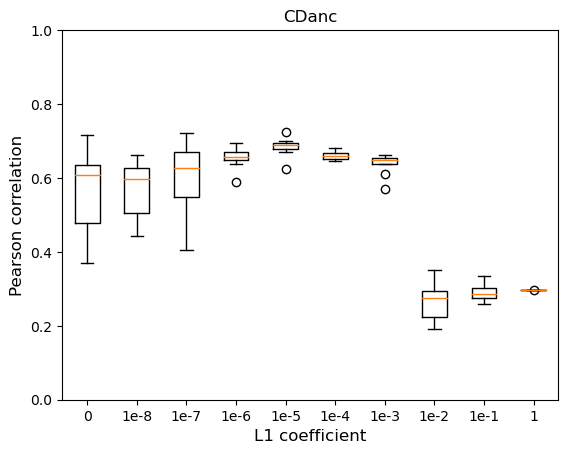

In [6]:
# Create boxplot
fig, ax = plt.subplots()
ax.boxplot(prediction_performance.T)  # Transpose so that each model's evaluations are plotted in separate box

# Set axis labels and title
ax.set_xlabel('L1 coefficient', fontsize=12)
ax.set_ylabel('Pearson correlation', fontsize=12)
ax.set_title(strain)

# Customize x-axis tick labels
ax.set_xticks(range(1, len(lmbdas) + 1))
ax.set_xticklabels(['0', '1e-8', '1e-7', '1e-6', '1e-5', '1e-4', '1e-3', '1e-2', '1e-1', '1'])
ax.set_ylim([0, 1.])

plt.savefig(f"figures/{strain}_performance_vs_L1.pdf")
plt.show()

In [7]:
# save parameters over trials, [trials, lmbdas, params]
params = np.zeros([10, 10, 240])

# import parameters from each trial
for trial in range(10):
    
    # import params
    param_df = pd.read_csv(f"L1scan/{strain}_params_{trial}.csv")
    
    # loop over lmbdas
    for lmbda_idx, lmbda in enumerate(lmbdas):
        
        # store parameters
        params[trial, lmbda_idx] = param_df[f'{lmbda}'].values

In [8]:
# set of HOI params
hoi_params = params[:, :, (8 + 8 ** 2):]
hoi_params.shape

(10, 10, 168)

In [9]:
# index of top 10 HOI parameters at optimal lmbda
lmbda_idx = lmbdas.index(1e-4)
sig_hoi_idx = np.argsort(np.abs(np.mean(hoi_params[:, lmbda_idx], 0)))[-20:]

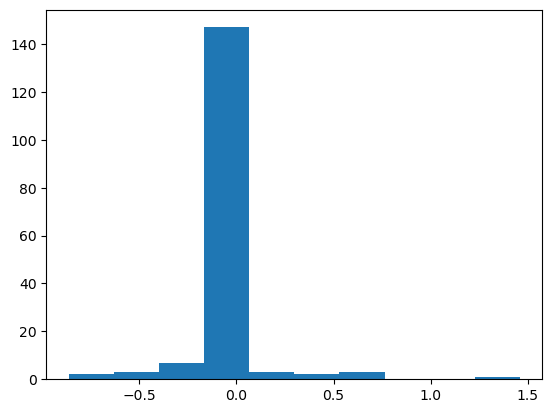

In [10]:
plt.hist(np.mean(hoi_params[:, lmbda_idx], 0))
plt.show()

In [11]:
param_df

,parameter,0.0,1e-08,1e-07,1e-06,1e-05,0.0001,0.001,0.01,0.1,1.0
0,CA,0.157348,0.196740,0.167942,0.165669,0.158937,0.257418,0.148428,0.139166,0.000040,0.000063
1,BT,1.053218,1.053884,1.064808,1.064079,1.074659,1.099928,1.016954,0.000690,0.244568,-0.000169
2,BU,0.919936,0.925769,0.915454,0.916007,0.926749,0.916946,0.840826,0.548365,0.208595,0.000068
3,CD,0.622360,0.623126,0.600221,0.627318,0.601506,0.600983,0.541468,0.185152,-0.000133,-0.000097
4,BV,0.766943,0.780640,0.740374,0.748867,0.755828,0.741624,0.660071,-0.000136,0.000074,-0.000156
...,...,...,...,...,...,...,...,...,...,...,...
235,CH<-[CD*CS],-3.836946,-1.336043,-3.671201,-2.595316,-0.003074,0.000025,-0.000043,-0.000138,-0.000073,-0.000141
236,CH<-[CD*DP],1.520415,1.777924,1.239557,0.595462,0.141852,-0.002718,0.000034,0.000145,-0.000045,-0.000123
237,CH<-[BV*CS],3.634090,4.319084,3.798921,1.649567,0.100047,0.000249,-0.000046,0.000268,0.000343,0.000104
238,CH<-[BV*DP],-5.348715,-5.714388,-5.917071,-4.514861,-3.121165,-0.005563,0.000107,-0.000040,0.000063,0.000105


In [12]:
hoi_param_names = param_df.parameter.values[72:]

In [13]:
# Define a custom color palette with distinct and vibrant colors
colors = [
    '#1f77b4',  # ER blue
    '#ff7f0e',  # FP orange
    '#26621E',  # AC green #2ca02c
    '#d62728',  # CC red
    '#9467bd',  # RI purple
    '#8c564b',  # DP brown
    '#e377c2',  # BH pink
    '#7f7f7f',  # CA gray
    '#bcbd22',  # PC yellow-green
    '#17becf',  # DL cyan
    '#1f23b8',  # CG blue (slightly different)
    '#e31a1c',  # BF dark red 
    '#fb9a99',  # EL light red
    '#ff7f00',  # BA vibrant orange
    '#fdbf6f',  # BO light orange
    '#ff7f90',  # BT dark orange
    '#cab2d6',  # BU light purple
    '#377eb8',  # BV dark blue
    '#a52eac',  # BC hot purple
    '#a6cee3',  # BY light blue
    '#b15928',  # PJ dark brown
    '#ff7f7f',  # DF light pink
    '#4daf4a',  # BL vibrant green
    '#384ea3',  # BP vibrant purple '#984ea3'
    '#e31a1c',  # CH dark red
]

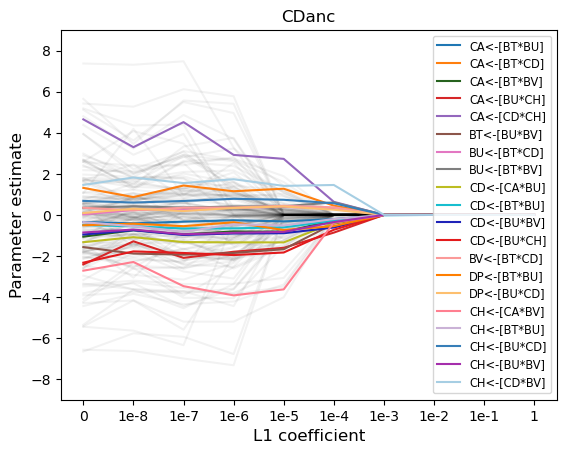

In [14]:

# Create boxplot
fig, ax = plt.subplots()

k = 0
for hoi_idx in range(hoi_params.shape[-1]):
    
    if hoi_idx in sig_hoi_idx:
        ax.plot(np.mean(hoi_params[:, :, hoi_idx], 0), c=colors[k], alpha=1., zorder=1, label=hoi_param_names[hoi_idx])
        k += 1
    else:
        ax.plot(np.mean(hoi_params[:, :, hoi_idx], 0), c='k', alpha=.05, zorder=0)

# add legend
ax.legend(loc='upper right', fontsize=8.2)
        
# Set axis labels and title
ax.set_xlabel('L1 coefficient', fontsize=12)
ax.set_ylabel('Parameter estimate', fontsize=12)
ax.set_title(strain)

# Customize x-axis tick labels
ax.set_ylim([-9, 9])
ax.set_xticks(range(len(lmbdas)))
ax.set_xticklabels(['0', '1e-8', '1e-7', '1e-6', '1e-5', '1e-4', '1e-3', '1e-2', '1e-1', '1'])

plt.savefig(f"figures/{strain}_estimate_vs_l1.pdf")
plt.show()